In [2]:
import cv2
import utils.ditmo_utils as du


/home/singh_a_WMGDS.WMG.WARWICK.AC.UK/py_env/hug/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from matplotlib import pyplot as plt
def show_array(data):
    plt.imshow(data, interpolation='nearest')
    plt.show()

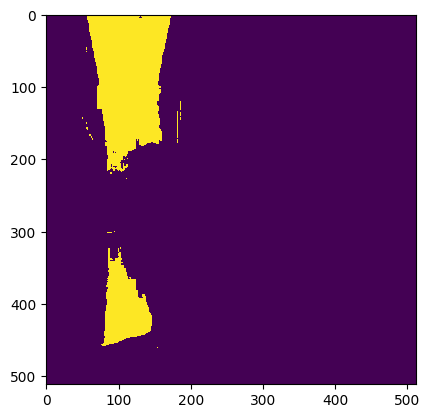

In [27]:
img_orig = cv2.imread("/home/singh_a_WMGDS.WMG.WARWICK.AC.UK/wmg/itmo/AutomateDITMO/paper_img/a0418.png")
img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
img, pad = du.resize_and_pad_image(img_orig)
img = du.pil_to_opencv(img)
saturated_mask = du.create_saturated_mask_stage0(img, saturation_threshold=240)
show_array(saturated_mask)

In [18]:
import numpy as np
bin_label = {
    1: [3],
    2: [14, 17, 35, 47, 69, 92, 95],
    3: [5, 10, 18, 30, 33, 67, 73, 126],
    4: [22, 27, 61, 110, 114, 129],
    5: [13, 127],
    6: [21, 77, 81, 84, 91, 103, 104, 105, 115, 117, 128, 133],
    7: [2, 7, 12, 26, 39, 43, 44, 49, 52, 53, 54, 55, 60, 62, 80, 85, 94, 97, 101, 102, 107, 116, 122, 137],
    8: [1, 4, 6, 8, 9, 11, 15, 16, 19, 20, 23, 24, 25, 28, 29, 31, 32, 34, 36, 40, 41, 42, 45, 46, 48, 50, 51, 56,
        57,
        58, 59, 65, 71, 72, 74, 76, 82, 89, 98, 100, 111, 146],
    9: [37, 38, 63, 64, 66, 68, 70, 75, 78, 79, 83, 86, 87, 88, 90, 93, 96, 99, 106, 108, 109, 112, 113, 118, 119,
        120,
        121, 123, 124, 125, 130, 131, 132, 134, 135, 136, 138, 139, 140, 141, 142, 143, 144, 145, 147, 148, 149,
        150]
}
lookuptable = np.zeros(151, dtype='uint8')
for key, val in bin_label.items():
    for i in range(1, 151):
        if i in val:
            lookuptable[i] = key

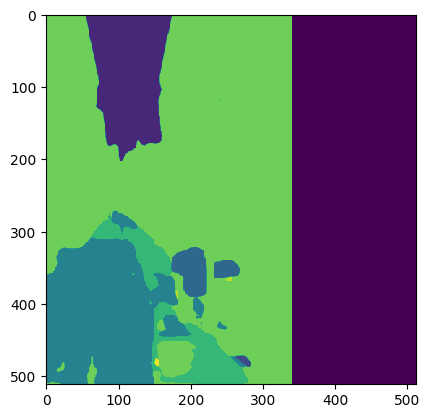

In [28]:
seg_im = cv2.imread("/home/singh_a_WMGDS.WMG.WARWICK.AC.UK/wmg/itmo/AutomateDITMO/mask/a0418.png")[:,:,0]
im_label = lookuptable[seg_im + 1]
im_label, _ = du.resize_and_pad_image(im_label)
im_label = du.pil_to_opencv(im_label)
show_array(im_label)


In [21]:
print(saturated_mask.shape)
print(im_label.shape)

(1441, 961)
(1441, 961)


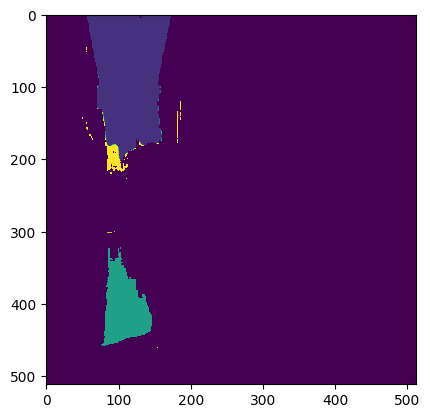

In [29]:
single_thres_mask_with_sep_class = cv2.bitwise_and(im_label, im_label, mask=saturated_mask)
show_array(single_thres_mask_with_sep_class)


In [30]:
saturated_class_indexes = du.get_semantic_inpainting_mask_list(single_thres_mask_with_sep_class)


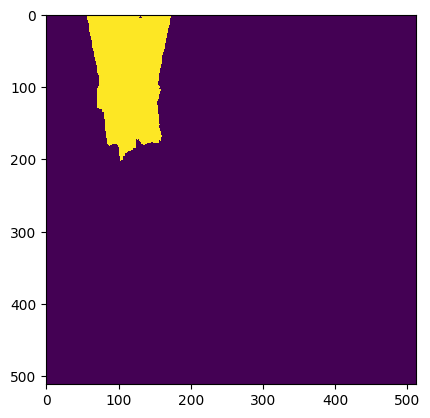

In [32]:
saturated_class = saturated_class_indexes[0]
one_class_mask_untouched = du.prune_mask(single_thres_mask_with_sep_class, saturated_class)
show_array(one_class_mask_untouched)

In [34]:
np.unique(one_class_mask_untouched)
one_class_mask_untouched.shape

(512, 512)

In [42]:
from PIL import Image
mask_img_to_pipe = Image.fromarray(one_class_mask_untouched)

In [47]:
len(mask_img_to_pipe.getbands())

1

In [60]:
input_img_to_pipe = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [62]:
PIL_input_img_to_pipe = Image.fromarray(input_img_to_pipe)

In [61]:
import torch

def ours_make_inpaint_condition(image, image_mask):
    image = image.astype(np.float32) / 255.0
    image_mask = image_mask.astype(np.float32) / 255.0

    assert image.shape[0:1] == image_mask.shape[0:1]
    image[image_mask > 0.5] = -1.0  # set as masked pixel
    image = np.expand_dims(image, 0).transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return image

control_image = ours_make_inpaint_condition(input_img_to_pipe, one_class_mask_untouched)

In [71]:
from VariableParams import *
from skimage.morphology import (erosion, dilation, opening, closing,  # noqa
                                white_tophat)
from skimage.util import img_as_ubyte

In [86]:
alpha_one_class_mask = du.createmattes_py(input_img_to_pipe, one_class_mask_untouched, border_t=5)
refined_alpha = alpha_one_class_mask.copy()
refined_alpha = np.where(refined_alpha < .98, 0, 1) * 255.0
# du.imshow(refined_alpha, 'class mask')
# refined_alpha = dilation(img_as_ubyte(refined_alpha.astype('uint8')), rad2)
eroded = erosion(img_as_ubyte(refined_alpha.astype('uint8')), pair2[0])

# ---------------------------------------------- Pre-process - Refine mask by morphological filters
# eroded = erosion(img_as_ubyte(one_class_mask_untouched.astype('uint8')), rad10)
one_class_mask = dilation(eroded, pair2[1])
my_try_class_mask = dilation(eroded, rad10)
# du.imshow(one_class_mask, 'class mask')
# --------------------------------------------------------Inpainting
mask_img_to_pipe = one_class_mask

In [74]:
control_image = ours_make_inpaint_condition(input_img_to_pipe, mask_img_to_pipe)

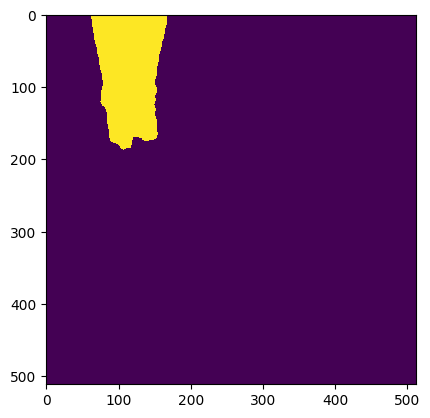

In [78]:
show_array(mask_img_to_pipe)

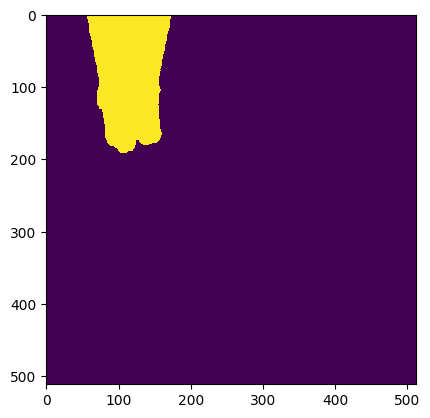

In [87]:
show_array(my_try_class_mask)

In [52]:
from diffusers.utils import load_image

init_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/controlnet-inpaint.jpg"
)
init_image = init_image.resize((512, 512))

mask_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/controlnet-inpaint-mask.jpg"
)
mask_image = mask_image.resize((512, 512))

In [53]:
type(mask_image)

PIL.Image.Image

In [54]:
init_image.size

(512, 512)

In [55]:
import numpy as np
import torch

def make_inpaint_condition(image, image_mask):
    image = np.array(image.convert("RGB")).astype(np.float32) / 255.0
    image_mask = np.array(image_mask.convert("L")).astype(np.float32) / 255.0

    assert image.shape[0:1] == image_mask.shape[0:1]
    image[image_mask > 0.5] = -1.0  # set as masked pixel
    image = np.expand_dims(image, 0).transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return image

control_image = make_inpaint_condition(init_image, mask_image)

In [56]:
from diffusers import StableDiffusionControlNetInpaintPipeline, ControlNetModel, UniPCMultistepScheduler

controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_inpaint", torch_dtype=torch.float16, use_safetensors=True)
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16, use_safetensors=True
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

Fetching 15 files:   7%|▋         | 1/15 [00:00<00:06,  2.24it/s]















































































































































































































































































































































































Loading pipeline components...:  86%|████████▌ | 6/7 [00:01<00:00,  5.83it/s]`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  4.3

In [75]:
output = pipe(
    "blue sky with cloud",
    num_inference_steps=20,
    eta=1.0,
    image=PIL_input_img_to_pipe,
    mask_image=mask_img_to_pipe,
    control_image=control_image,
).images[0]

/home/singh_a_WMGDS.WMG.WARWICK.AC.UK/py_env/hug/lib/python3.10/site-packages/diffusers/image_processor.py:203: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-1.0,1.0]
  warnings.warn(
100%|██████████| 20/20 [00:02<00:00,  9.86it/s]


In [76]:
type(output)

PIL.Image.Image

In [77]:
output.show()

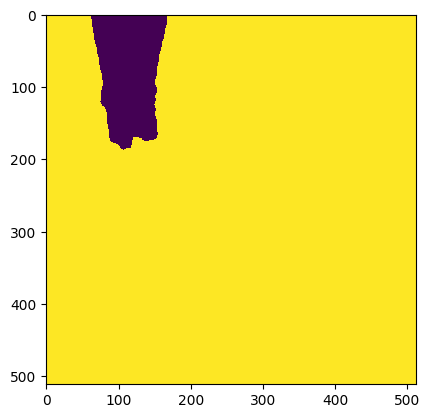

In [80]:
inverse_mask = cv2.bitwise_not(mask_img_to_pipe)
show_array(inverse_mask)

In [94]:
output_array = np.array(output)
control_image = ours_make_inpaint_condition(output_array, inverse_mask)

In [95]:
mask_img_to_pipe = Image.fromarray(inverse_mask)

In [96]:
output = pipe(
    "blue sky with cloud",
    num_inference_steps=20,
    eta=1.0,
    image=output,
    mask_image=mask_img_to_pipe,
    control_image=control_image,
).images[0]

/home/singh_a_WMGDS.WMG.WARWICK.AC.UK/py_env/hug/lib/python3.10/site-packages/diffusers/image_processor.py:203: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-1.0,1.0]
  warnings.warn(
100%|██████████| 20/20 [00:02<00:00,  9.69it/s]


In [97]:
output.show()

# New pipe

In [98]:
import cv2
import utils.ditmo_utils as du
from matplotlib import pyplot as plt
def show_array(data):
    plt.imshow(data, interpolation='nearest')
    plt.show()
from PIL import Image
import torch
from VariableParams import *
from skimage.morphology import (erosion, dilation, opening, closing,  # noqa
                                white_tophat)
from skimage.util import img_as_ubyte
import numpy as np

In [99]:
def ours_make_inpaint_condition(image, image_mask):
    image = image.astype(np.float32) / 255.0
    image_mask = image_mask.astype(np.float32) / 255.0

    assert image.shape[0:1] == image_mask.shape[0:1]
    image[image_mask > 0.5] = -1.0  # set as masked pixel
    image = np.expand_dims(image, 0).transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return image

def inpainting(pipe, input_img_to_pipe, mask_img_to_pipe, prompt):

    # Create control image
    control_image = ours_make_inpaint_condition(input_img_to_pipe, mask_img_to_pipe)

    # Run pipe
    output = pipe(
        prompt,
        num_inference_steps=20,
        eta=1.0,
        image=Image.fromarray(input_img_to_pipe),
        mask_image=Image.fromarray(mask_img_to_pipe),
        control_image=control_image,
    ).images[0]
    return output

In [100]:
bin_label = {
    1: [3],
    2: [14, 17, 35, 47, 69, 92, 95],
    3: [5, 10, 18, 30, 33, 67, 73, 126],
    4: [22, 27, 61, 110, 114, 129],
    5: [13, 127],
    6: [21, 77, 81, 84, 91, 103, 104, 105, 115, 117, 128, 133],
    7: [2, 7, 12, 26, 39, 43, 44, 49, 52, 53, 54, 55, 60, 62, 80, 85, 94, 97, 101, 102, 107, 116, 122, 137],
    8: [1, 4, 6, 8, 9, 11, 15, 16, 19, 20, 23, 24, 25, 28, 29, 31, 32, 34, 36, 40, 41, 42, 45, 46, 48, 50, 51, 56,
        57,
        58, 59, 65, 71, 72, 74, 76, 82, 89, 98, 100, 111, 146],
    9: [37, 38, 63, 64, 66, 68, 70, 75, 78, 79, 83, 86, 87, 88, 90, 93, 96, 99, 106, 108, 109, 112, 113, 118, 119,
        120,
        121, 123, 124, 125, 130, 131, 132, 134, 135, 136, 138, 139, 140, 141, 142, 143, 144, 145, 147, 148, 149,
        150]
}
lookuptable = np.zeros(151, dtype='uint8')
for key, val in bin_label.items():
    for i in range(1, 151):
        if i in val:
            lookuptable[i] = key

from diffusers import StableDiffusionControlNetInpaintPipeline, ControlNetModel, UniPCMultistepScheduler

controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_inpaint", torch_dtype=torch.float16, use_safetensors=True)
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16, use_safetensors=True
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

# Read image
img_orig = cv2.imread("/home/singh_a_WMGDS.WMG.WARWICK.AC.UK/wmg/itmo/AutomateDITMO/paper_img/a0418.png")
img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
img, pad = du.resize_and_pad_image(img_orig)
img = du.pil_to_opencv(img)
saturated_mask = du.create_saturated_mask_stage0(img, saturation_threshold=240)
input_img_to_pipe = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Read segmentation mask
seg_im = cv2.imread("/home/singh_a_WMGDS.WMG.WARWICK.AC.UK/wmg/itmo/AutomateDITMO/mask/a0418.png")[:,:,0]
im_label = lookuptable[seg_im + 1]
im_label, _ = du.resize_and_pad_image(im_label)
im_label = du.pil_to_opencv(im_label)

single_thres_mask_with_sep_class = cv2.bitwise_and(im_label, im_label, mask=saturated_mask)
saturated_class_indexes = du.get_semantic_inpainting_mask_list(single_thres_mask_with_sep_class)

Loading pipeline components...:  86%|████████▌ | 6/7 [00:00<00:00,  7.44it/s]`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  5.48it/s]


In [101]:
    # Only use first class for inpainting
saturated_class = saturated_class_indexes[0]
one_class_mask_untouched = du.prune_mask(single_thres_mask_with_sep_class, saturated_class)

# Errosion and Dialation
alpha_one_class_mask = du.createmattes_py(input_img_to_pipe, one_class_mask_untouched, border_t=5)
refined_alpha = alpha_one_class_mask.copy()
refined_alpha = np.where(refined_alpha < .98, 0, 1) * 255.0
eroded = erosion(img_as_ubyte(refined_alpha.astype('uint8')), pair1[0])
one_class_mask = dilation(eroded, pair1[1])
mask_img_to_pipe = one_class_mask

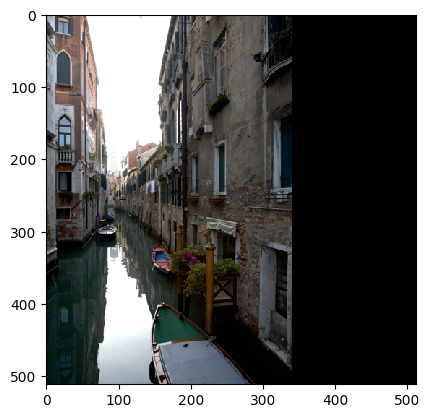

In [102]:
show_array(input_img_to_pipe)

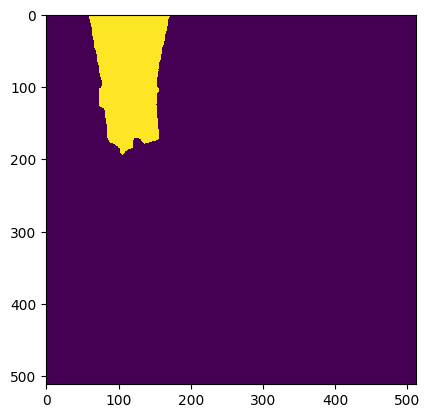

In [103]:
show_array(mask_img_to_pipe)

In [105]:
prompt = "Sky with clouds"
output = inpainting(pipe, input_img_to_pipe, mask_img_to_pipe, prompt)
output.save("out.png")

/home/singh_a_WMGDS.WMG.WARWICK.AC.UK/py_env/hug/lib/python3.10/site-packages/diffusers/image_processor.py:203: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-1.0,1.0]
  warnings.warn(
100%|██████████| 20/20 [00:02<00:00,  9.51it/s]


In [106]:
# expand inapinting
inverse_mask = cv2.bitwise_not(mask_img_to_pipe)

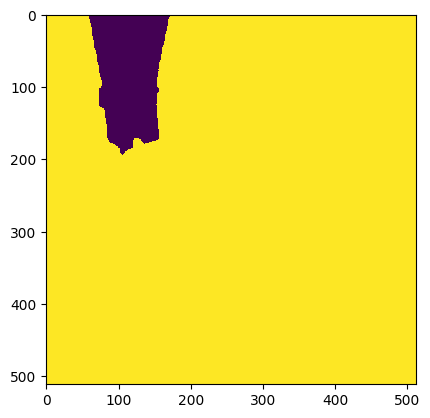

In [107]:
show_array(inverse_mask)

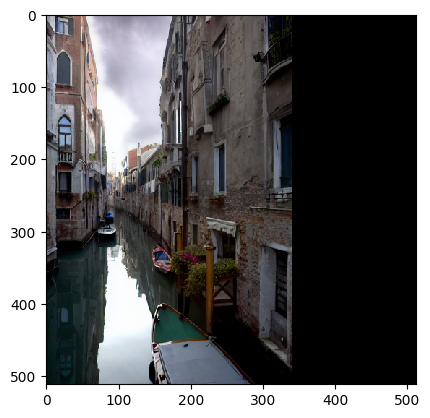

In [108]:
show_array(np.array(output))

In [109]:
inverse_mask = cv2.bitwise_not(mask_img_to_pipe)
output1 = inpainting(pipe, np.array(output), inverse_mask, prompt)
output1.save("out1.png")

/home/singh_a_WMGDS.WMG.WARWICK.AC.UK/py_env/hug/lib/python3.10/site-packages/diffusers/image_processor.py:203: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-1.0,1.0]
  warnings.warn(
100%|██████████| 20/20 [00:02<00:00,  9.44it/s]


In [110]:
# Only use first class for inpainting
saturated_class = saturated_class_indexes[1]
one_class_mask_untouched = du.prune_mask(single_thres_mask_with_sep_class, saturated_class)

In [111]:
# Errosion and Dialation
alpha_one_class_mask = du.createmattes_py(np.array(output), one_class_mask_untouched, border_t=5)
refined_alpha = alpha_one_class_mask.copy()
refined_alpha = np.where(refined_alpha < .98, 0, 1) * 255.0
eroded = erosion(img_as_ubyte(refined_alpha.astype('uint8')), pair1[0])
one_class_mask = dilation(eroded, pair1[1])
mask_img_to_pipe = one_class_mask

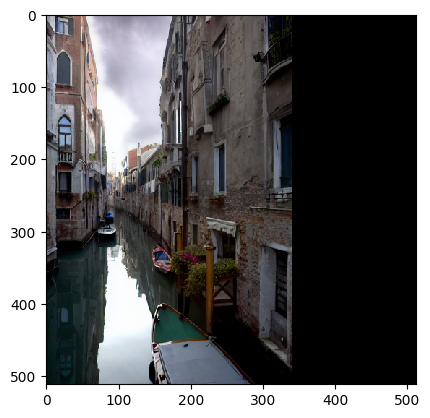

In [112]:
show_array(np.array(output))

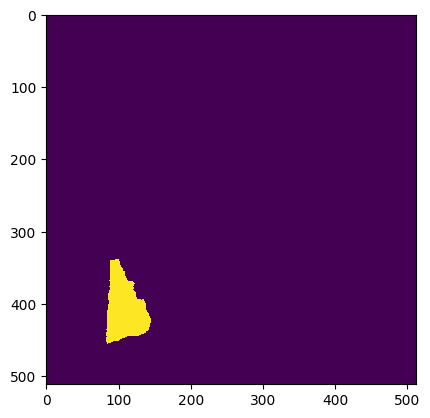

In [113]:
show_array(mask_img_to_pipe)

In [114]:
prompt = "Water with reflection of sky"
output3 = inpainting(pipe, np.array(output), mask_img_to_pipe, prompt)
output3.save("out3.png")

/home/singh_a_WMGDS.WMG.WARWICK.AC.UK/py_env/hug/lib/python3.10/site-packages/diffusers/image_processor.py:203: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-1.0,1.0]
  warnings.warn(
100%|██████████| 20/20 [00:02<00:00,  9.75it/s]


In [115]:
inverse_mask = cv2.bitwise_not(mask_img_to_pipe)

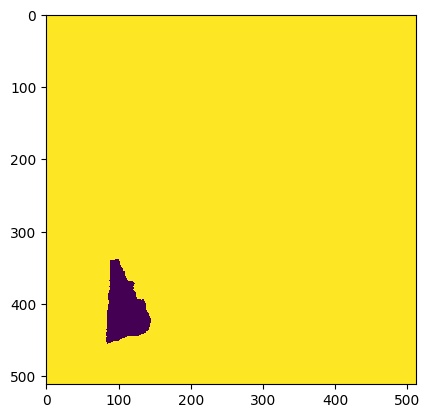

In [116]:
show_array(inverse_mask)

In [117]:
output4 = inpainting(pipe, np.array(output3), inverse_mask, prompt)
output4.save("out4.png")

/home/singh_a_WMGDS.WMG.WARWICK.AC.UK/py_env/hug/lib/python3.10/site-packages/diffusers/image_processor.py:203: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-1.0,1.0]
  warnings.warn(
100%|██████████| 20/20 [00:02<00:00,  9.44it/s]
